In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
from scipy import stats
from sklearn import linear_model
from sklearn.feature_selection import f_regression
from sklearn.model_selection import KFold

In [112]:
df = pd.read_excel('table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls', header=4)

In [113]:
df.head()

,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
0,Adams Village,1861.0,0.0,0.0,NaN,0.0,0.0,0.0,12.0,2.0,10.0,0.0,0.0
1,Addison Town and Village,2577.0,3.0,0.0,NaN,0.0,0.0,3.0,24.0,3.0,20.0,1.0,0.0
2,Akron Village,2846.0,3.0,0.0,NaN,0.0,0.0,3.0,16.0,1.0,15.0,0.0,0.0
3,Albany,97956.0,791.0,8.0,NaN,30.0,227.0,526.0,4090.0,705.0,3243.0,142.0,NaN
4,Albion Village,6388.0,23.0,0.0,NaN,3.0,4.0,16.0,223.0,53.0,165.0,5.0,NaN


## Preparing data set

Preparing a data set to use with linear regression(multivariable), we're using these variables: Population, Murder, robbery, and Property crime. We will use these to predict our target variable, property crime. 

In [114]:
#removing first rape column every entry was NAN
df = df.drop('Rape\n(revised\ndefinition)1', axis=1)

#removing last three rows NAN values
df = df.drop([348,349,350])

#renaming columns
df.columns = ['City', 'Population', 'Violent', 'Murder', 'Rape', 'Robbery', 'Aggravated assault',
              'Property crime', 'Burglary','Larceny theft', 'Motor vehicle theft', 'Arson']

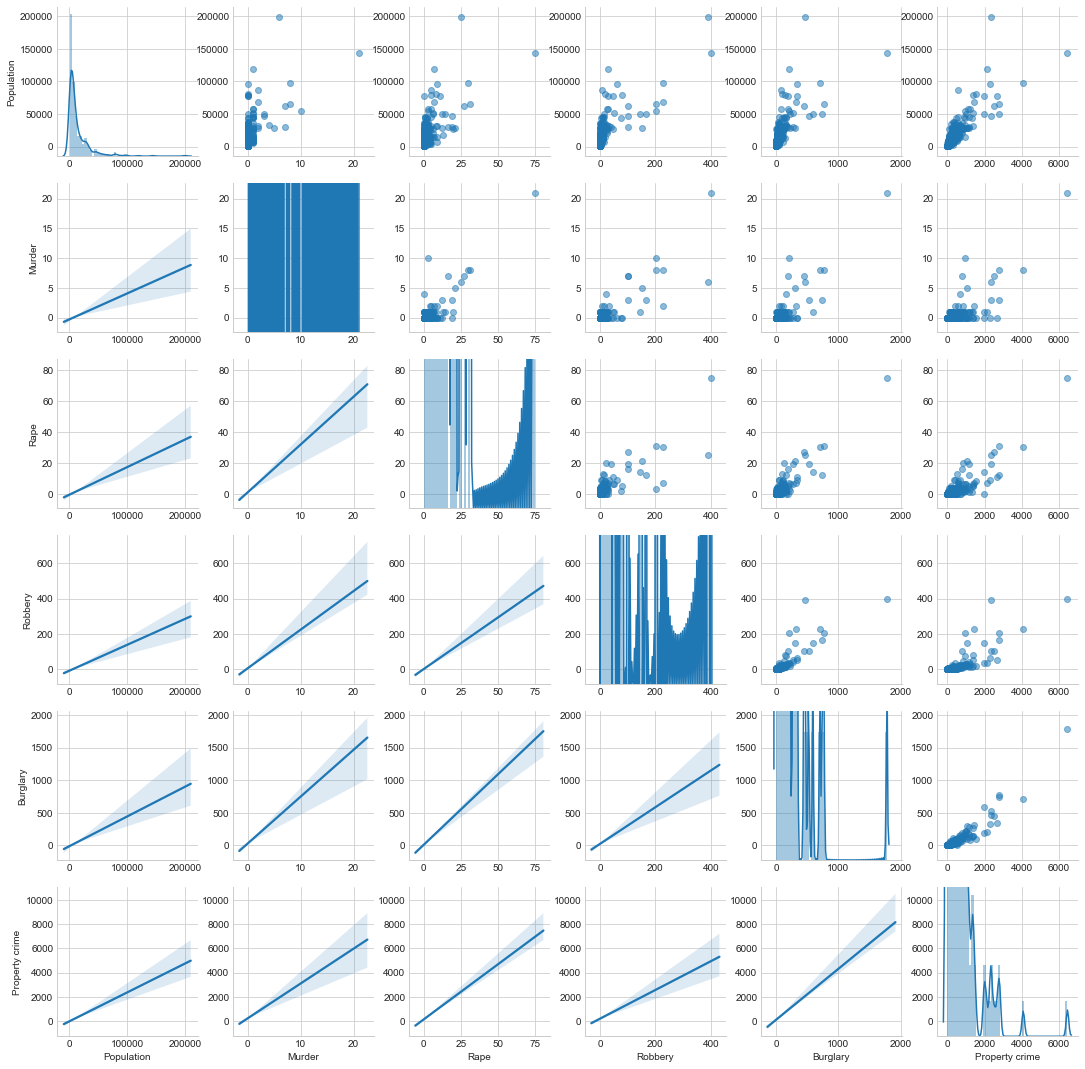

In [115]:
#Reducing dataframe columns to variables of interest
newdf = df[['City', 'Population', 'Murder', 'Rape', 'Robbery', 'Burglary', 'Property crime']]

#droping some outlier, to make graphs intuitive
newdf = newdf.drop(216)
newdf = newdf.drop(272)
newdf = newdf.drop(35)

#Plotting scatter plot matrix
g = sns.PairGrid(newdf)
g.map_upper(plt.scatter, alpha=.5)
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
g.map_diag(sns.distplot)
plt.show()

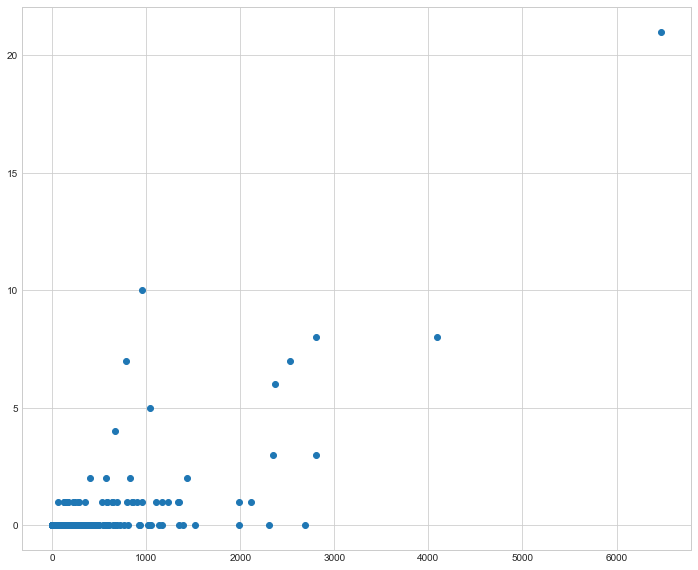

In [116]:
plt.subplots(figsize=(12,10)) 
plt.scatter(newdf['Property crime'], newdf['Murder'])
plt.show()

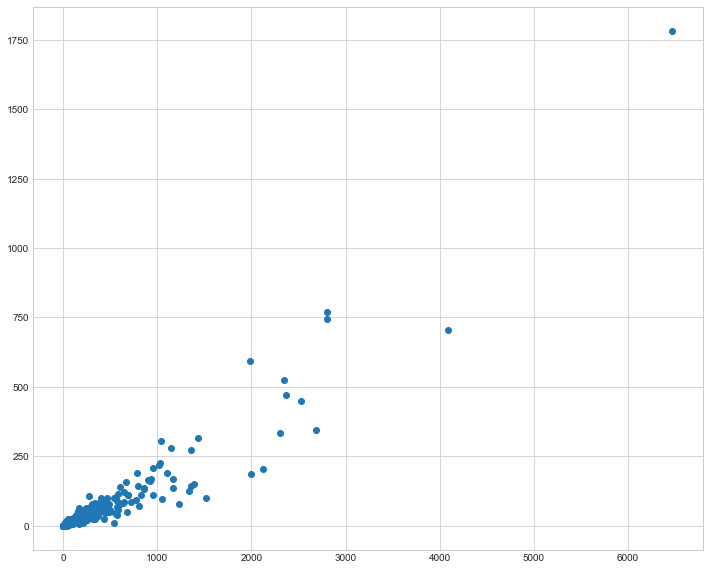

In [117]:
plt.subplots(figsize=(12,10)) 
plt.scatter(newdf['Property crime'], newdf['Burglary'])
plt.show()

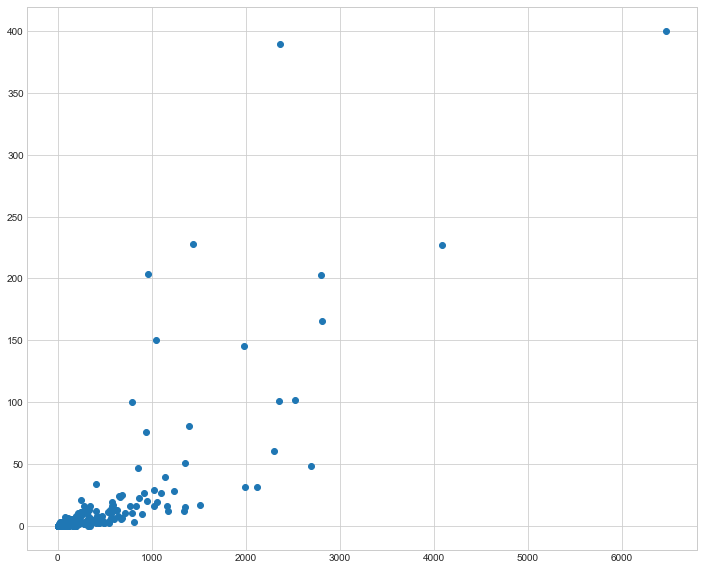

In [118]:
plt.subplots(figsize=(12,10)) 
plt.scatter(newdf['Property crime'], newdf['Robbery'])
plt.show()

In [119]:
df.loc[df['Population'] > 100000]

,City,Population,Violent,Murder,Rape,Robbery,Aggravated assault,Property crime,Burglary,Larceny theft,Motor vehicle theft,Arson
7,Amherst Town,118296.0,107.0,1.0,7.0,31.0,68.0,2118.0,204.0,1882.0,32.0,3.0
35,Buffalo,258789.0,3249.0,47.0,145.0,1322.0,1735.0,12491.0,3458.0,8076.0,957.0,NaN
216,New York,8396126.0,52384.0,335.0,1112.0,19170.0,31767.0,141971.0,16606.0,117931.0,7434.0,NaN
272,Rochester,210562.0,2107.0,42.0,92.0,918.0,1055.0,10051.0,2587.0,6855.0,609.0,132.0
310,Syracuse,143834.0,1192.0,21.0,75.0,400.0,696.0,6473.0,1781.0,4298.0,394.0,57.0
346,Yonkers,199134.0,1036.0,6.0,25.0,390.0,615.0,2368.0,470.0,1662.0,236.0,10.0


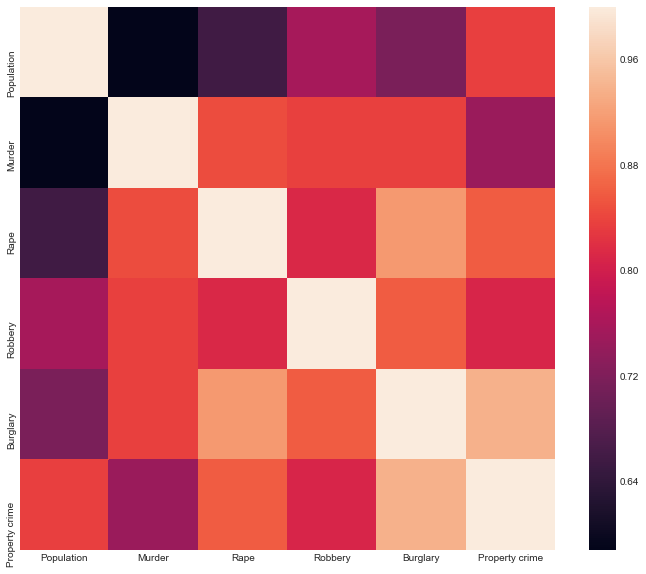

In [120]:
plt.subplots(figsize=(12,10)) 
sns.heatmap(newdf.corr())
plt.show()

## Feature extraction

Squaring populations, Changing murder and robbery to binary categorical features

In [121]:
#squaring population
df['Pop_squared'] = df['Population'] * df['Population']
#Creating binary categorical feature out of continuous variable columns, murder and robbery.
df['Murder_f'] = np.where((df['Murder'] == 0), 0, 1)
df['robbery_f']  = np.where((df['Robbery'] == 0), 0, 1)

In [122]:
#Reducing columns
df[['City', 'Property crime', 'Population', 'Murder', 'Robbery']].head()

,City,Property crime,Population,Murder,Robbery
0,Adams Village,12.0,1861.0,0.0,0.0
1,Addison Town and Village,24.0,2577.0,0.0,0.0
2,Akron Village,16.0,2846.0,0.0,0.0
3,Albany,4090.0,97956.0,8.0,227.0
4,Albion Village,223.0,6388.0,0.0,4.0


## Modeling

Setting up multivariable linear regression model.

In [123]:
regr = linear_model.LinearRegression()
kf = KFold(n_splits=5)


Y = df['Property crime']
X = df[['Population', 'Murder', 'Robbery', 'Burglary']]
prediction = []

for train, test in kf.split(X, Y):
    data_train, data_test = X.iloc[train], X.iloc[test]
    target_train, target_test = Y.iloc[train], Y.iloc[test]
    regr.fit(data_train, target_train)
    prediction.extend(regr.predict(data_test))
    print('Rsquared:',regr.score(X, Y))

Rsquared: 0.999556267861
Rsquared: 0.999587302257
Rsquared: 0.999587568051
Rsquared: 0.943552107322
Rsquared: 0.999565106191


In [124]:
# Calculating F-test and P-values for each feature.
f_test, p_values = f_regression(X, Y)
f_test /= np.max(f_test)

i = 0
for name in X.columns:
    print(name)
    print('f_test:  {}'.format(f_test[i]))
    print('p_value: {}\n'.format(p_values[i]))
    i += 1

Population
f_test:  0.4706623896057136
p_value: 0.0

Murder
f_test:  0.38185517037450817
p_value: 0.0

Robbery
f_test:  1.0
p_value: 0.0

Burglary
f_test:  0.13478218025879685
p_value: 1.400754021308374e-277



In [131]:
# Importing new data set(california crime) to test model on new data
cali_df = pd.read_excel('table_8_offenses_known_to_law_enforcement_california_by_city_2013.xls', header=4)

#Cleaning data set for modeling
cali_df = cali_df.drop('Rape\n(revised\ndefinition)1', axis=1)

cali_df.columns = ['City', 'Population', 'Violent', 'Murder', 'Rape', 'Robbery', 'Aggravated assault',
              'Property crime', 'Burglary','Larceny theft', 'Motor vehicle theft', 'Arson']

cali_df = cali_df.drop([462, 463])

In [130]:
#executing model
Y = cali_df['Property crime']
X = cali_df[['Population', 'Murder', 'Robbery', 'Burglary']]

regr.predict(X)
print('Rsquared:',regr.score(X, Y))

Rsquared: 0.93808522081


In [132]:
# Calculating F-test and P-values for each feature.
f_test, p_values = f_regression(X, Y)
f_test /= np.max(f_test)

i = 0
for name in X.columns:
    print(name)
    print('f_test:  {}'.format(f_test[i]))
    print('p_value: {}\n'.format(p_values[i]))
    i += 1

Population
f_test:  0.45542303394644534
p_value: 1.0328868789833713e-219

Murder
f_test:  0.28851056604965325
p_value: 1.9393030036524324e-180

Robbery
f_test:  0.39739763377646575
p_value: 9.844017979284707e-208

Burglary
f_test:  1.0
p_value: 6.217084723207067e-292

